# ETF 종목 클러스터링 && Self Organizing Map
* 본 강의에서 학습했던 Clustering 중 강의에서 다루지는 않았던 Self Organizing Map을 이용해 보고자 합니다.
* ETF 종목을 클러스터링 하고자 합니다. Feature를 이용해서 Clustering 한 결과가, ETF의 Category와 얼마나 유사하게 일치하는지를 비교 검증 해보고자 합니다.
* 데이터 Sample은 아래와 같습니다.
  * 2022-01-01 ~ 2022-06-30 기간 중 거래가 유지된 종목( 중간에 상장되거나, 중간에 상폐 된 종목은 제외 ) == 530 종목
* 사용하고자 하는 Feature는 다음과 같습니다.
  * 종목코드
  * 카테고리
  * 6개월 구간 수익률( Feature 1 )
  * 6개월 구간 상장좌수 변동률( Feature 2 )

### 0. Prerequisite
* 본 과정에서는 SOM을 테스트 해보기 위해서 minisom 패키지를 설치한다.
* 시각화를 위해서 Bokeh도 설치한다.

In [73]:
!pip install minisom
!pip install bokeh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1. Load data
* 사용할 데이터를 준비한다.

In [74]:
import pandas as pd

srcs = pd.read_csv( 'ETF.20220812.csv' )
srcs.head()

,code,name,category,price_return,share_return
0,A069500,KODEX 200,주식-시장대표,-22.744902,15.248468
1,A069660,KOSEF 200,주식-시장대표,-22.895033,-20.388350
2,A091160,KODEX SEMICON,주식-업종섹터-정보기술,-31.933508,17.741935
3,A091170,KODEX BANKs,주식-업종섹터-금융,-18.283828,-14.229765
4,A091180,KODEX AUTOs,주식-업종섹터-경기소비재,-18.760234,4.115226


In [75]:
# Y 값으로 사용할 Column
data_y = srcs[ [ 'category' ] ]
data_y.head()

,category
0,주식-시장대표
1,주식-시장대표
2,주식-업종섹터-정보기술
3,주식-업종섹터-금융
4,주식-업종섹터-경기소비재


In [76]:
# X 값으로 사용할( 학습 재료로 사용할 ) Column
data_x = srcs[ [ 'price_return', 'share_return' ] ]
print( data_x.shape )
data_x.head()

(530, 2)


,price_return,share_return
0,-22.744902,15.248468
1,-22.895033,-20.388350
2,-31.933508,17.741935
3,-18.283828,-14.229765
4,-18.760234,4.115226


### 2. Normalizing
* 설명 변수를 동일한 Scale로 정규화 한다.
* Scale 전에 데이터를 다시 한번 확인해 본다.

In [77]:
data_x.describe()

,price_return,share_return
count,530.000000,530.000000
mean,-15.037465,54.904993
std,17.981312,437.839017
min,-68.158103,-87.096774
25%,-23.498613,-0.750331
50%,-17.830340,0.950989
75%,-6.454575,25.000000
max,58.963585,8621.052632


In [78]:
import numpy as np

# 정규화 수행, 표준 정규 분포를 이용해서 정규화를 진행한다.
data_x = ( data_x - np.mean( data_x, axis = 0 ) ) / np.std( data_x, axis = 0 )

print( data_x.shape )
data_x.head()

(530, 2)


,price_return,share_return
0,-0.429041,-0.090659
1,-0.437398,-0.172128
2,-0.940532,-0.084959
3,-0.180712,-0.158049
4,-0.207231,-0.116111


### 3. Model 생성 및 결과 비교
* Hyper parameter를 여러 Collection 형태로 입력하여 N개의 Model 생성
* Model 별로 Quantization Error, Cluster 개수 정보를 담은 객체를 만든다.
* Parameter에 사용한 항목은 아래와 같다.
  * Map size
  * Neighborhood 반경
  * 학습률
  * 초기값 설정 방법

In [79]:
# 각 파라미터 초기화

param_map = list( range( 2, 6 ) )
param_sigma = [ np.round( sigma * 0.1, 2 ) for sigma in range( 1, 10 ) ]
param_lrnrate = [ np.round( lr * 0.1, 2 ) for lr in range( 1, 10 ) ]

print( 'MAP: {} '.format( param_map ) )
print( 'Neighborhood: {} '.format( param_sigma ) )
print( 'Learning rate: {} '.format( param_lrnrate ) )

MAP: [2, 3, 4, 5] 
Neighborhood: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 
Learning rate: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 


In [80]:
# 조합을 만든다.
import itertools

param_product = list( itertools.product( param_map, param_sigma, param_lrnrate ) )
print( param_product )

[(2, 0.1, 0.1), (2, 0.1, 0.2), (2, 0.1, 0.3), (2, 0.1, 0.4), (2, 0.1, 0.5), (2, 0.1, 0.6), (2, 0.1, 0.7), (2, 0.1, 0.8), (2, 0.1, 0.9), (2, 0.2, 0.1), (2, 0.2, 0.2), (2, 0.2, 0.3), (2, 0.2, 0.4), (2, 0.2, 0.5), (2, 0.2, 0.6), (2, 0.2, 0.7), (2, 0.2, 0.8), (2, 0.2, 0.9), (2, 0.3, 0.1), (2, 0.3, 0.2), (2, 0.3, 0.3), (2, 0.3, 0.4), (2, 0.3, 0.5), (2, 0.3, 0.6), (2, 0.3, 0.7), (2, 0.3, 0.8), (2, 0.3, 0.9), (2, 0.4, 0.1), (2, 0.4, 0.2), (2, 0.4, 0.3), (2, 0.4, 0.4), (2, 0.4, 0.5), (2, 0.4, 0.6), (2, 0.4, 0.7), (2, 0.4, 0.8), (2, 0.4, 0.9), (2, 0.5, 0.1), (2, 0.5, 0.2), (2, 0.5, 0.3), (2, 0.5, 0.4), (2, 0.5, 0.5), (2, 0.5, 0.6), (2, 0.5, 0.7), (2, 0.5, 0.8), (2, 0.5, 0.9), (2, 0.6, 0.1), (2, 0.6, 0.2), (2, 0.6, 0.3), (2, 0.6, 0.4), (2, 0.6, 0.5), (2, 0.6, 0.6), (2, 0.6, 0.7), (2, 0.6, 0.8), (2, 0.6, 0.9), (2, 0.7, 0.1), (2, 0.7, 0.2), (2, 0.7, 0.3), (2, 0.7, 0.4), (2, 0.7, 0.5), (2, 0.7, 0.6), (2, 0.7, 0.7), (2, 0.7, 0.8), (2, 0.7, 0.9), (2, 0.8, 0.1), (2, 0.8, 0.2), (2, 0.8, 0.3), (2, 0.8, 

In [81]:
len( set( x[ 0 ] for x in srcs[ ['category'] ].values ) )

51

In [82]:
# Case 별로 돌린다.
from minisom import MiniSom

wrap, fail = list(), list()
for case in param_product:

  map_i, sigma_i, lr_i = case
  # print( 'Done: {}'.format( str( case ) ) )
  try:
    model_rnd = MiniSom( map_i, map_i, 2, sigma = sigma_i, learning_rate = lr_i, topology = 'hexagonal', random_seed = 0 )
    model_rnd.random_weights_init( data_x.values )
    model_rnd.train( data_x.values, 1000, random_order = True )
    qe_rnd = model_rnd.quantization_error( data_x.values )
    winners_rnd = np.array( [ model_rnd.winner( x ) for x in data_x.values ] ).T
    cluster_idx_rnd = np.ravel_multi_index( winners_rnd, ( map_i, map_i ) )
    wrap.append( [
        '{m}x{m}'.format( m = str( map_i ) ), sigma_i, lr_i, 'random_init', qe_rnd, len( np.unique( cluster_idx_rnd ) )
    ] )

    model_pca = MiniSom( map_i, map_i, 2, sigma = sigma_i, learning_rate = lr_i, topology = 'hexagonal', random_seed = 0 )
    model_pca.pca_weights_init( data_x.values )
    model_pca.train( data_x.values, 1000, random_order = True )
    qe_pca = model_pca.quantization_error( data_x.values )
    winners_pca = np.array( [ model_pca.winner( x ) for x in data_x.values ] ).T
    cluster_idx_pca = np.ravel_multi_index( winners_pca, ( map_i, map_i ) )
    wrap.append( [
        '{m}x{m}'.format( m = str( map_i ) ), sigma_i, lr_i, 'pca_init', qe_pca, len( np.unique( cluster_idx_pca ) )
    ] )
    
  except Exception as err:
    print( str( err ) )
    fail.append( case )

rest = pd.DataFrame( wrap, columns = [ 'map_size', 'sigma', 'learning_rate', 'init_method', 'qe', 'n_cluster' ] )
print( rest.shape )
rest.sort_values( by = [ 'qe' ], ascending = True, inplace = True, ignore_index = True )
rest.head()

(648, 6)


,map_size,sigma,learning_rate,init_method,qe,n_cluster
0,5x5,0.7,0.9,pca_init,0.128501,25
1,5x5,0.2,0.3,random_init,0.131919,25
2,5x5,0.1,0.3,random_init,0.131919,25
3,5x5,0.3,0.3,random_init,0.132195,25
4,5x5,0.2,0.4,random_init,0.132387,25


In [83]:
# 전체적으로 확인해 본다.
rest

,map_size,sigma,learning_rate,init_method,qe,n_cluster
0,5x5,0.7,0.9,pca_init,0.128501,25
1,5x5,0.2,0.3,random_init,0.131919,25
2,5x5,0.1,0.3,random_init,0.131919,25
3,5x5,0.3,0.3,random_init,0.132195,25
4,5x5,0.2,0.4,random_init,0.132387,25
...,...,...,...,...,...,...
643,2x2,0.1,0.4,pca_init,0.609449,3
644,2x2,0.2,0.4,pca_init,0.609449,3
645,2x2,0.3,0.5,pca_init,0.617350,3
646,2x2,0.2,0.5,pca_init,0.617350,3


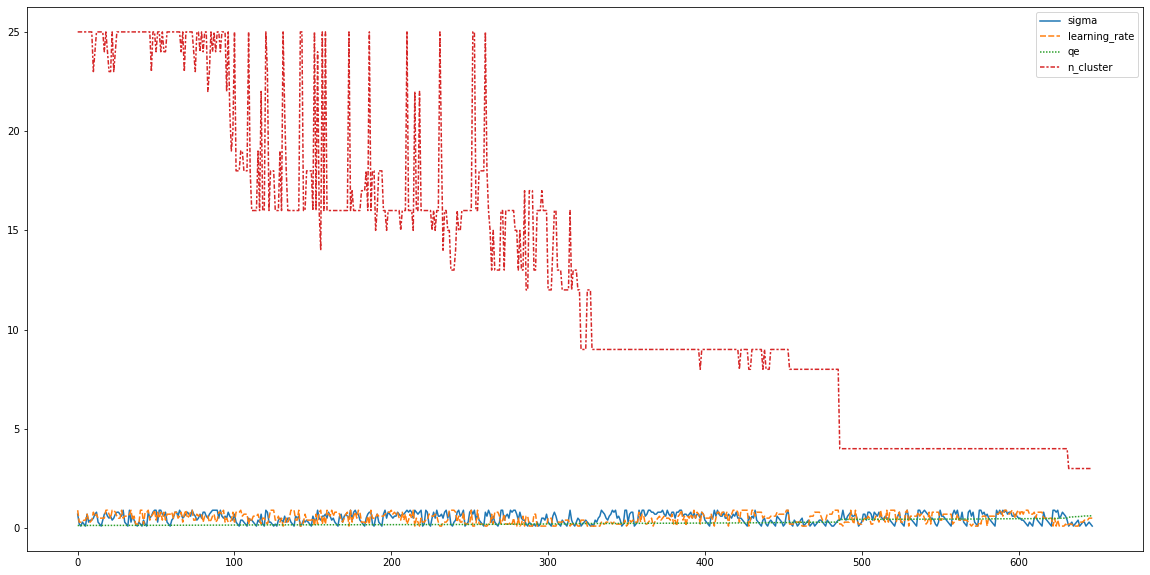

In [84]:
# 그래프를 그려서 결과를 확인해 본다.

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure( figsize = ( 20, 10 ) )
sns.lineplot( data = rest )

### 4. 최적 값 선택
* 기존 KRX의 ETF Category는 총 51개이다. 하지만, 여기서는 2단계까지의 Clustering을 수행해 보겠다. ( 채권, 주식 등... )
* 고로, 위 결과에서 Clustering = 9 에서 QE 값이 작게 나온 Parameter set을 이용하고자 한다. 

In [85]:
# 결과 중 ( 내가 원하는 환경의 ) 최적 값 골라내기

rest[ rest[ 'n_cluster' ] == 9 ]

,map_size,sigma,learning_rate,init_method,qe,n_cluster
321,3x3,0.1,0.4,random_init,0.227381,9
322,3x3,0.2,0.4,random_init,0.227381,9
323,3x3,0.3,0.4,random_init,0.227381,9
324,3x3,0.4,0.4,random_init,0.227672,9
328,3x3,0.2,0.1,random_init,0.231341,9
...,...,...,...,...,...,...
449,3x3,0.3,0.7,random_init,0.275595,9
450,3x3,0.1,0.7,random_init,0.275595,9
451,3x3,0.2,0.7,random_init,0.275595,9
452,3x3,0.7,0.9,pca_init,0.277593,9


In [86]:
# Map: 3x3, Sigma: 0.1, Learning rate: 0.4 를 사용하고자 한다.

model_picked = MiniSom( 
    3, 3, 2, sigma = 0.1, learning_rate = 0.4, topology = 'hexagonal',
    neighborhood_function = 'gaussian', activation_distance = 'euclidean',
    random_seed = 0
)

# setup
model_picked.random_weights_init( data_x.values )
model_picked.train( data_x.values, 1000, random_order = True )

qe_of_model_picked = model_picked.quantization_error( data_x.values )
winners = np.array( [ model_picked.winner( x ) for x in data_x.values ] ).T
cluster_index = np.ravel_multi_index( winners, ( 3, 3 ) )
print( qe_of_model_picked ) # 똑같이 나왔다.

0.22738133533571403


### 5. Visualize
* 도식화 하여 어떻게 Clustering이 이루어 졌는지 확인해 본다.
* U-Matrix에 Scatter plot을 그려본다.

   cluster 이름   개수
0           0   65
1           1    3
2           2   61
3           3  157
4           4   83
5           5  114
6           6   15
7           7   24
8           8    8


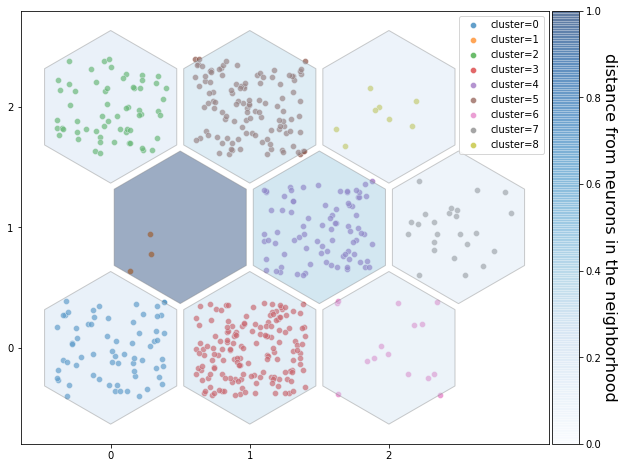

In [87]:
from matplotlib.patches import RegularPolygon
from matplotlib.colorbar import ColorbarBase
from matplotlib import cm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

xx, yy = model_picked.get_euclidean_coordinates()
umatrix = model_picked.distance_map()
weights = model_picked.get_weights()

f = plt.figure( figsize = ( 10, 10 ) )
ax = f.add_subplot( 111 )
ax.set_aspect( 'equal' )

# 하나씩 hexagon 추가
# plotting the distance map as background
# 해당 셀과 다른 이웃들 간 거리를 표현, 밝을수록 가깝고, 어두울수록 멀다
for i in range( weights.shape[ 0 ] ):
    for j in range( weights.shape[ 1 ] ):
        wy = yy[ ( i, j ) ] * 2 / np.sqrt( 3 ) * 3 / 4
        hex = RegularPolygon(
            ( xx[ ( i, j ) ], wy ),
            numVertices = 6,
            radius = .95 / np.sqrt( 3 ),
            facecolor = cm.Blues( umatrix[ i, j ] ),
            alpha = .4, edgecolor = 'gray' 
        )
        plot = ax.add_patch( hex )

#output노드에 해당하는 클러스터 종류 및 밀도 확인         
cnt = list()
for c in np.unique(cluster_index):
  x_ = [ 
      model_picked.convert_map_to_euclidean( model_picked.winner( x ) )[ 0 ] + 
      ( 2 * np.random.rand( 1 )[ 0 ] - 1 ) * 0.4 for x in data_x.values[ cluster_index == c ]
  ]
  y_ = [
      model_picked.convert_map_to_euclidean( model_picked.winner( x ) )[ 1 ] + 
      ( 2 * np.random.rand( 1 )[ 0 ] - 1 ) * 0.4 for x in data_x.values[ cluster_index == c ]
  ]
  y_ = [ ( i * 2 / np.sqrt( 3 ) * 3 / 4 ) for i in y_ ]
    
  plot = sns.scatterplot( x = x_, y= y_, label = 'cluster=' + str( c ), alpha = .7 )
        
  #클러스터에 속한 데이터 개수 데이터프레임으로 출력
  cnt.append( [ c, len( x_ ) ] )

#클러스터별 개수를 표 형태로 출력 
df_cnt = pd.DataFrame( cnt, columns = [ 'cluster 이름', '개수' ] )
print( df_cnt )

#x축,y축 간격 설정 
xrange = np.arange( weights.shape[ 0 ] )
yrange = np.arange( weights.shape[ 1 ] )
plot = plt.xticks( xrange - .5, xrange )
plot = plt.yticks( yrange * 2 / np.sqrt( 3 ) * 3 / 4, yrange )

#차트 우측에 color bar생성
divider = make_axes_locatable( plt.gca() )
ax_cb = divider.new_horizontal( size = "5%", pad = 0.05 )    
cb1 = ColorbarBase( ax_cb, cmap = cm.Blues, orientation = 'vertical', alpha = .4 )
cb1.ax.get_yaxis().labelpad = 16
plot = cb1.ax.set_ylabel( 'distance from neurons in the neighborhood', rotation = 270, fontsize = 16 )
plot = plt.gcf().add_axes( ax_cb )


In [88]:
srcs[ 'category' ] = srcs[ 'category' ].apply( lambda x: x if x.count( '-' ) < 2 else x[ : x.rindex( '-' ) ] )

In [89]:
# 결과를 실제로 보고 싶다. 어떤 종목들끼리 Clustering 되었는지... 위 그래프와 연결해서 생각해 본다.

final_report = pd.concat( [ srcs, pd.DataFrame( cluster_index, columns = [ 'cluster' ] ) ], axis = 1 )
cset = sorted( set( x[ 0 ] for x in final_report[ [ 'cluster' ] ].values ) )

for clst in cset:
  pick = final_report.query( 'cluster == {}'.format( clst ) )
  print( '{}: {}'.format( clst, len( pick ) ) )
  print( pick.groupby( [ 'category' ] ).size(), '\n' )
  # pick_cset = sorted( set( x[ 0 ] for x in pick[ [ 'category' ] ].values ) )
  # pick_cset = sorted( set( [ x if x.count( '-' ) < 2 else x[ : x.rindex( '-' ) ] for x in pick_cset ] ) )
  # print( pick_cset, '\n' )

0: 65
category
기타          5
부동산-리츠      1
원자재-금속      6
주식-시장대표     9
주식-업종섹터    10
주식-전략       5
채권-국공채     19
채권-혼합       6
채권-회사채      2
통화-미국달러     2
dtype: int64 

1: 3
category
원자재-에너지    2
주식-전략      1
dtype: int64 

2: 61
category
주식-시장대표    22
주식-업종섹터    34
주식-전략       4
채권-국공채      1
dtype: int64 

3: 157
category
부동산-리츠      3
주식-규모       6
주식-시장대표    62
주식-업종섹터    41
주식-전략      43
채권-국공채      2
dtype: int64 

4: 83
category
부동산            1
부동산-리츠         1
원자재-금속         4
주식-시장대표       13
주식-업종섹터       16
주식-전략         11
채권-국공채        13
채권-혼합          4
채권-회사채         3
통화-미국달러        2
통화-일본엔         1
혼합자산-주식+채권    13
혼합자산-채권+리츠     1
dtype: int64 

5: 114
category
부동산-리츠         1
원자재-금속         2
주식-규모          8
주식-시장대표       26
주식-업종섹터       29
주식-전략         38
채권-국공채         4
채권-회사채         1
통화-미국달러        3
혼합자산           1
혼합자산-주식+채권     1
dtype: int64 

6: 15
category
주식-시장대표    7
주식-업종섹터    8
dtype: int64 

7: 24
category
원자재-농산물     3
주식-시장대표    14
주식-업종섹

In [90]:
for clst in cset:
  print( clst )
  print( final_report.query( 'cluster == {}'.format( clst ) )[ 'name' ], '\n' )

0
8                              KODEX China H
17                               TIGER LATIN
30                               TIGER China
33                                 KOSEF MSB
38                       KOSEF Enhanced Cash
                       ...                  
496             SOL IHS Markit Global Carbon
500     HANARO Global Carbon Futures (Synth)
503               KINDEX S&P US Dividend 100
521                 KINDEX KRX Physical Gold
529    SOL China Photovoltaic CSI(Synthetic)
Name: name, Length: 65, dtype: object 

1
123                          KODEX Sams Value
127                      TIGER WTI INVERSE(H)
238    KODEX WTI Crude Oil Futures Inverse(H)
Name: name, dtype: object 

2
2                               KODEX SEMICON
6                           TIGER SEMICON ETF
36                          TIGER200 Leverage
79                            KINDEX Leverage
85                             TIGER SOFTWARE
                        ...                  
519              

### 6. 결론
* 0, 2, 3, 4, 5 Cluster로 많이 묶였다.
* 결과를 보면 0, 2, 3, 4, 5 Cluster에 가장 많은 종목들이 모여 있는데 내용을 잘 살펴 보면, 5개 Cluster 모두 아래 2개 카테고리가 다수를 차지하고 있다.
  * 주식 - 시장대표
  * 주식 - 업종대표
* 이는 2가지를 암시한다. 
  * 모델의 결과가 Clustering을 하는데 그렇게 큰 효과가 없었거나,
  * KRX의 분류 체계가 실제 분류에 큰 도움이 되지 않는다거나 이다.

* 그래서 Cluster 별로 실제 포함되어 있는 종목들의 이름을 들여다 봤다. 그 결과,
  * 1개 Cluster내 모든 종목이 전부 유사한 카테고리를 가진것은 아니지만,
  * 유사한 상품끼리는 같은 클러스터 내에 포진되어 있다.
    * 예를 들면, 특정 Benchmark의 Future, Inverse 들이 같이 모여 있다.
* 직관적으로는 당연한 이야기이지만, 기간내 수익률과 상장주식수의 변동률을 이용해서 역으로 Clustering 한 결과가 어느 정도 유의미한 결과를 내놓는다는 결론에 이를수 있다.
* Cluster의 개수를 늘리거나, KRX의 카테고리 분류체계가 좀더 실질적인 형태로 변화된다면, 보다 나은 결과가 나올 것이라고 생각한다.
* 아울러 ETF의 여러 Feature를 이용해서 SOM Clustering을 해보는 것도 의미가 있을 것이라 생각한다.


---

* 짧지만 계절 학기 동안 양질의 강의를 제공해 주셔서 감사합니다. 
* 코로나에 건강 유의하시기 바랍니다.

### Reference
* https://github.com/JustGlowing/minisom 